In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv; from flopy.utils import Mf6ListBudget 
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
sim_name = "p06_beta_mf6" ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; example_name = sim_name
output_folder = Path("./ex-RES/p06")                ; output_folder.mkdir(exist_ok=True) ; example_name=sim_name
output_folder2 = Path('./ex-RES/p06/p06_beta_mf6')  ; output_folder.mkdir(exist_ok=True) ; workspace = output_folder

In [3]:
# Model parameters
length_units = "feet" ; time_units = "days" ; nlay=1 ;  nrow=31 ;  ncol=31  ;  delr=900.0 ;  delc=900.0 ;  delz=20.0 ;  top=0.0 ;  prsity=0.35 
dum1=2.5  ;  dum2=7.5 ;  k11=432.0 ;  qwell=1.0  ;  cwell=100.0 ;  al=100.0 ;  trpt=1.0   ; dmcoef = 0 ; k33 = k11        ; k11 = 0.005 * 86400
perlen = [912.5, 2737.5] ; nper = len(perlen)    ; nstp = [36.5, 109.5]     ; tsmult = [1, 1]          ; dt0 = 56.25 ; sconc = 0.0 ; c0 = 0.0 
ath1 = al * trpt ; botm = [top - delz]  ; icelltype = 0 ; mixelm = -1 ; strt = np.zeros((nlay, nrow, ncol), dtype=float)
ibound_mf2k5 = np.ones((nlay, nrow, ncol), dtype=int) * -1    ; ibound_mf2k5[:, 1 : nrow - 1, 1 : ncol - 1] = 1
idomain = np.ones((nlay, nrow, ncol), dtype=int)              ; icbund = 1
qwell = 86400.0  ; cwell = 100.0                              ; spd_mf6 = {0: [[(0, 15, 15), qwell, cwell]] , 1: [[(0, 15, 15), -qwell , 0.0]]} 
chdspd = []
for i in np.arange(nrow):
    chdspd.append([(0, i, 0), strt[0, i, 0]])  ; chdspd.append([(0, i, ncol - 1), strt[0, i, ncol - 1]])
for j in np.arange(1, ncol - 1):
    chdspd.append([(0, 0, j), strt[0, 0, j]])  ; chdspd.append([(0, nrow - 1, j), strt[0, nrow - 1, j]])
chdspd = {0: chdspd}
nouter = 100 ; ninner = 300 ;  hclose = 1e-6 ;  rclose = 1e-6 ;  relax  = 1.0 ; percel = 1.0 ; itrack = 3 ; wd = 0.5  
dceps = 1.0e-5 ; nplane = 1 ; npl = 0 ; nph = 16 ; npmin = 2 ; npmax = 32 ; dchmoc = 1.0e-3 ; nlsink = nplane ; npsink = nph 
name = "p06-mf6" ;   gwfname = "gwf-" + name  ; gwtname = "gwt_" + name

In [4]:
def build_models(sim_name, mixelm=0, silent=False):
    name = "p06-mf6"  ;     gwfname = "gwf-" + name  # MODFLOW 6 ____________________________________________
    sim_ws = os.path.join(output_folder, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf (sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms (sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                   inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                   scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package      (imsgwf, [gwf.name])

    flopy.mf6.ModflowGwfdis      (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=int),filename=f"{gwfname}.dis")
    flopy.mf6.ModflowGwfnpf (gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    flopy.mf6.ModflowGwfsto (gwf, ss=0, sy=0, filename=f"{gwfname}.sto")   
    flopy.mf6.ModflowGwfic  (gwf, strt=strt, filename=f"{gwfname}.ic")       
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
                              printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])                         
    gwtname = "gwt_" + name  # ________________________________________________________________________________________ MF6 ___________
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")
    gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,
                                  linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method="NONE",
                                  relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None, distcoef=None,filename=f"{gwtname}.mst")  
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
#   flopy.mf6.ModflowGwtoc(gwt)    # LAST ONE
    flopy.mf6.ModflowGwtoc(gwt, budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
                           printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")])
    obslist = [["BCKGRND", "concentration", (0, 15, 15)]]                     ; obsdict = {f"{gwtname}.obs.csv": obslist}     # (16x , 16y)
    obs = flopy.mf6.ModflowUtlobs(gwt, print_input=False, continuous = obsdict)  # obsdict     
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)                                ; assert success, pformat(buff)

In [5]:
def plot_results(mf6, idx, ax=None):
    mf6_out_path = mf6.simulation_data.mfpath.get_sim_path() ; mf6.simulation_data.mfpath.get_sim_path()
    fname = os.path.join(mf6_out_path, list(mf6.model_names)[1] + ".obs.csv")  ; mf6cobs = flopy.utils.Mf6Obs(fname).data   # OBS Transport
    
    with styles.USGSPlot():
        sim_name = mf6.name     ;         plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]              # MF6 (mf6.c.OBS)   x    # cvt
        if ax is None:
            fig = plt.figure(figsize=(5, 2), dpi=100, tight_layout=True)                                ; ax = fig.add_subplot(1, 1, 1)
        x_mf6      = mf6cobs["totim"] / 365.0  ; y_mf6 = mf6cobs["BCKGRND"] ; x_mf6_pare = x_mf6[::20]  ; y_mf6_pare = y_mf6[::20]
        
        ax.plot(x_mf6_pare, y_mf6_pare, label="MODFLOW 6", marker="x", linestyle=":")                    ; plt.xlim(0, 10) ; plt.ylim(0, 100.0)   
        plt.xlabel("Time, in years")      ; plt.ylabel("Normalized [C] % ") ; plt.legend()    ;  title = "[C] Injection / Pumping (16x, 16y)"
        letter = chr(ord("@") + idx + 1)  ; styles.heading(letter=letter, heading=title)
        if plot_show:
            plt.show()

run_models took 1883.89 ms


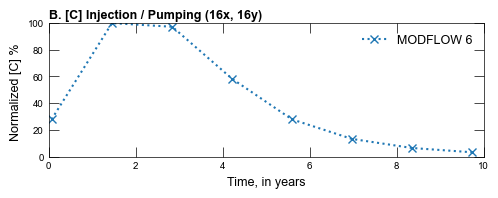

In [6]:
def scenario(idx, silent=True):
    sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(sim)
    if run:
        run_models(sim)
    if plot:
        plot_results(sim, idx)
scenario(1)  # 1,-1,0

In [7]:
# flopy.mf6.ModflowTdis         flopy.mf6.ModflowGwtdis
perlen = [912.5, 2737.5] ; nper = len(perlen) ; nstp = [365, 1095] ; tsmult = [1.0, 1.0]
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
np.set_printoptions(precision=2)                   ; tdis_rc2 = np.array(tdis_rc, ndmin=2)  ; tdis_rc3 = np.array(tdis_rc, ndmin=2) /365 

print('years', tdis_rc3.round(decimals=1)) ; np.set_printoptions(suppress=True) , tdis_rc2

years [[2.5 1.  0. ]
 [7.5 3.  0. ]]


(None,
 array([[ 912.5,  365. ,    1. ],
        [2737.5, 1095. ,    1. ]]))

In [8]:
print(sum(nstp))

1460


In [9]:
perlen_mf = [912.5, 2737.5] ; nprs = 100  ; timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = True) ; timprs 

array([   0.  ,   36.87,   73.74,  110.61,  147.47,  184.34,  221.21,
        258.08,  294.95,  331.82,  368.69,  405.56,  442.42,  479.29,
        516.16,  553.03,  589.9 ,  626.77,  663.64,  700.51,  737.37,
        774.24,  811.11,  847.98,  884.85,  921.72,  958.59,  995.45,
       1032.32, 1069.19, 1106.06, 1142.93, 1179.8 , 1216.67, 1253.54,
       1290.4 , 1327.27, 1364.14, 1401.01, 1437.88, 1474.75, 1511.62,
       1548.48, 1585.35, 1622.22, 1659.09, 1695.96, 1732.83, 1769.7 ,
       1806.57, 1843.43, 1880.3 , 1917.17, 1954.04, 1990.91, 2027.78,
       2064.65, 2101.52, 2138.38, 2175.25, 2212.12, 2248.99, 2285.86,
       2322.73, 2359.6 , 2396.46, 2433.33, 2470.2 , 2507.07, 2543.94,
       2580.81, 2617.68, 2654.55, 2691.41, 2728.28, 2765.15, 2802.02,
       2838.89, 2875.76, 2912.63, 2949.49, 2986.36, 3023.23, 3060.1 ,
       3096.97, 3133.84, 3170.71, 3207.58, 3244.44, 3281.31, 3318.18,
       3355.05, 3391.92, 3428.79, 3465.66, 3502.53, 3539.39, 3576.26,
       3613.13, 3650

In [10]:
sim = flopy.mf6.MFSimulation.load(sim_ws = output_folder2 , exe_name=exe_name , verbosity_level=0) ; ml = sim.get_model("gwf-p06-mf6")
gwf = sim.get_model('gwf-p06-mf6'); hobj = gwf.output.head() ; head = hobj.get_alldata()  ;  times = hobj.get_times()  
print("OC package_Flow  : ", ml.oc.output.methods()) ; print('T_headss', head.shape) ; t= pd.DataFrame(times) ; t.to_csv(output_folder/"a_T.csv")

OC package_Flow  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']
T_headss (145, 1, 31, 31)


In [11]:
sim = flopy.mf6.MFSimulation.load(sim_ws = output_folder2 , exe_name=exe_name , verbosity_level=0) ; mt = sim.get_model("gwt_p06-mf6")
gwt = sim.get_model('gwt_p06-mf6'); ucnobj = gwt.output.concentration() ; conc = ucnobj.get_alldata() ;  times = ucnobj.get_times()
print("OC package_trans  : ", mt.oc.output.methods()) ; print('T_conc', conc.shape) 

OC package_trans  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'concentration()']
T_conc (145, 1, 31, 31)


In [12]:
h2 = head.reshape(head.shape[0],-1);  c2 = conc.reshape(conc.shape[0],-1);  print(h2.shape)
h2=pd.DataFrame(h2)  ; h2.to_csv (output_folder /"c_H.csv"); c2=pd.DataFrame(c2)  ; c2.to_csv (output_folder /"d_C.csv")

(145, 961)


In [13]:
mfl = Mf6ListBudget(output_folder2 / 'gwf-p06-mf6.lst')             ; flux,_vol = mfl.get_dataframes(start_datetime='2023-08-02 10:52:00')   
flux,_vol.to_csv(output_folder / "b_flow_budget.csv")  ;  flux.head()   
ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')

Text(0, 0.5, 'Percent mass balance error')

In [14]:
fname = os.path.join  (output_folder2/ f"{gwtname}.obs.csv")  
mf6gwt_ra=flopy.utils.Mf6Obs(fname).data  ; mf6conc=mf6gwt_ra["BCKGRND"]   ;tn=pd.DataFrame(mf6conc) ;tn.to_csv(output_folder/"eL_C.csv")

heads (1, 31, 31)


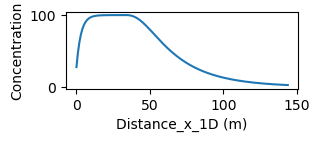

In [16]:
fname = os.path.join (output_folder2/ f"{gwfname}.hds")    
hdobj = flopy.utils.HeadFile(fname); heads=hdobj.get_data() ;heads2=heads[0,:,:] ;tn=pd.DataFrame(heads2) ;tn.to_csv(output_folder/"fL_H.csv")
times = hdobj.get_times()  ; print('heads',heads.shape)  
ttimes   =  pd.DataFrame(times)                          ; ttimes.to_csv(output_folder/"gL_T.csv")
plt.figure(figsize=(3, 1))  ; plt.plot(mf6conc)          ; plt.xlabel('Distance_x_1D (m)')   ; plt.ylabel('Concentration') ; plt.show()